# Pruebas

## Definiciones

In [41]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from numpy import load, savez

def getNPZ(name):
    filename = f'./images/processed_images/{name}_01_projected_w.npz'
    return load(filename)['w']

def normalize_vectors(vectors):
    """Normaliza una lista de vectores usando norma L2."""
    original_shape = vectors.shape  # Guardamos la forma original
    vectors = vectors.reshape(vectors.shape[0], -1)  # Aplanamos a (N, D)
    vectors = normalize(vectors, axis=1)  # Normalizamos en la dimensión correcta
    return vectors.reshape(original_shape)  # Restauramos la forma original


## Cargar los datos

In [42]:
def check_npz(df):
    npz_encontrados = []
    npz_no_encontrados = []
    for i, image in df.iterrows():
        name = image['name']
        if not os.path.exists(f'/mnt/discoAmpliado/viky/images/processed_images/{name}_01_projected_w.npz'):
            npz_no_encontrados.append(name)
        else:
            npz_encontrados.append(name)
    if len(npz_no_encontrados) != 0:
        print("NO se encontraron todos los npz")
        return npz_no_encontrados
    else:
        print("SI se encontraron todos los npz")
        return npz_no_encontrados

In [43]:
# Cargar datos y ejecutar procesos
df = pd.read_csv('./dataframe.csv')

print(f'Tamaño total del dataframe: {df.shape}')
npz_no_encontrados = check_npz(df)
df = df[~df['name'].isin(npz_no_encontrados)]
df

Tamaño total del dataframe: (2499, 10)
SI se encontraron todos los npz


,gender,id,exp,exp_level,race,attribute,ext,name,raw_image_folder,idUnique
0,F,30,FE,2,BL,F2D,bmp,F0030_FE02BL_F2D,/mnt/discoAmpliado/viky/BU_3DFE/F0030,0030F
1,F,30,AN,2,BL,F2D,bmp,F0030_AN02BL_F2D,/mnt/discoAmpliado/viky/BU_3DFE/F0030,0030F
2,F,30,FE,1,BL,F2D,bmp,F0030_FE01BL_F2D,/mnt/discoAmpliado/viky/BU_3DFE/F0030,0030F
3,F,30,SU,3,BL,F2D,bmp,F0030_SU03BL_F2D,/mnt/discoAmpliado/viky/BU_3DFE/F0030,0030F
4,F,30,DI,1,BL,F2D,bmp,F0030_DI01BL_F2D,/mnt/discoAmpliado/viky/BU_3DFE/F0030,0030F
...,...,...,...,...,...,...,...,...,...,...
2494,M,26,SU,1,AE,F2D,bmp,M0026_SU01AE_F2D,/mnt/discoAmpliado/viky/BU_3DFE/M0026,0026M
2495,M,26,SA,4,AE,F2D,bmp,M0026_SA04AE_F2D,/mnt/discoAmpliado/viky/BU_3DFE/M0026,0026M
2496,M,26,HA,1,AE,F2D,bmp,M0026_HA01AE_F2D,/mnt/discoAmpliado/viky/BU_3DFE/M0026,0026M
2497,M,26,SA,1,AE,F2D,bmp,M0026_SA01AE_F2D,/mnt/discoAmpliado/viky/BU_3DFE/M0026,0026M


## Primera exploración

In [44]:
def restar_vectores_neutros(df):
    """Resta el vector neutro de cada persona a sus otras imágenes"""
    adjusted_vectors = []
    
    for person_id, group in df.groupby('idUnique'):
        neutral_vector = None
        
        # Buscar la imagen neutra
        for _, row in group.iterrows():
            if row['exp'] == 'NE':
                neutral_vector = getNPZ(row['name'])
                break
        
        # Si no hay imagen neutra, dejamos los vectores como están
        if neutral_vector is None:
            print(f"Advertencia: No se encontró imagen neutra para {person_id}")
            adjusted_vectors.extend([getNPZ(row['name']) for _, row in group.iterrows()])
            continue
        
        # Restar el vector neutro de las otras imágenes
        for _, row in group.iterrows():
            vector = getNPZ(row['name'])
            adjusted_vectors.append(vector - neutral_vector)
    
    df['adjusted_vector'] = adjusted_vectors
    return df

df = restar_vectores_neutros(df)

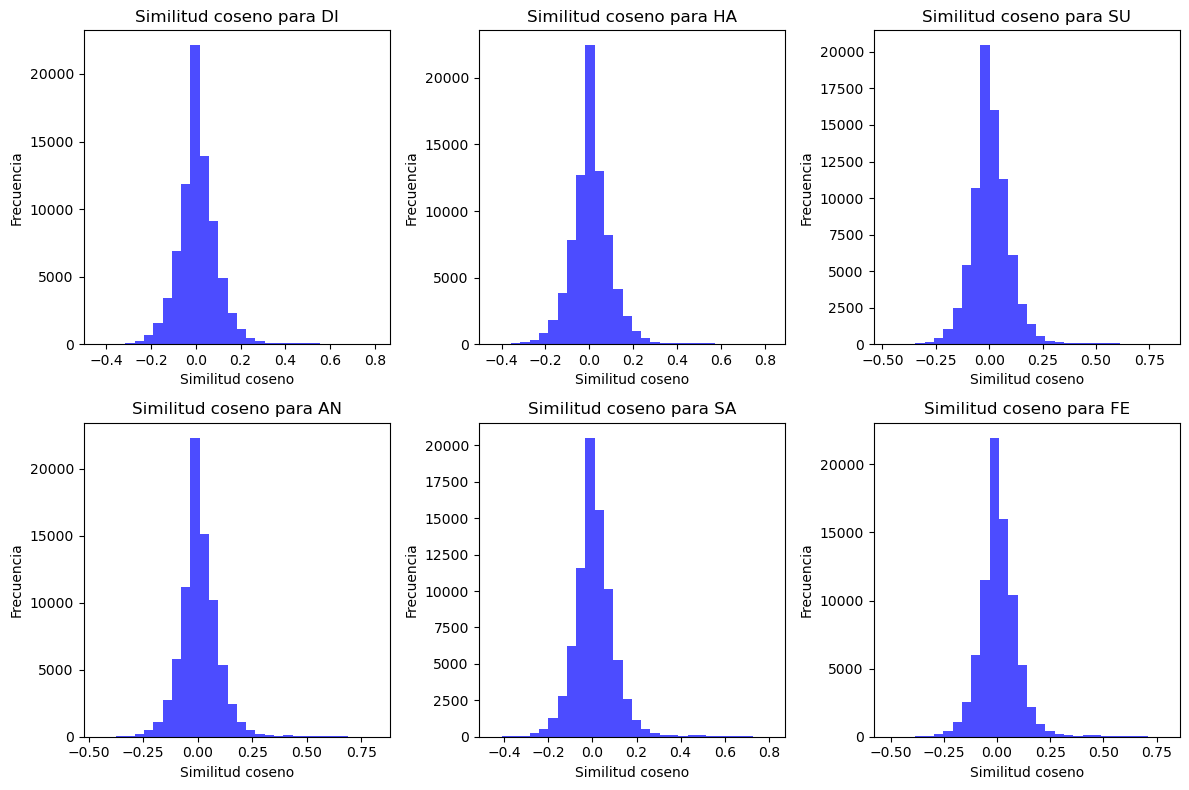

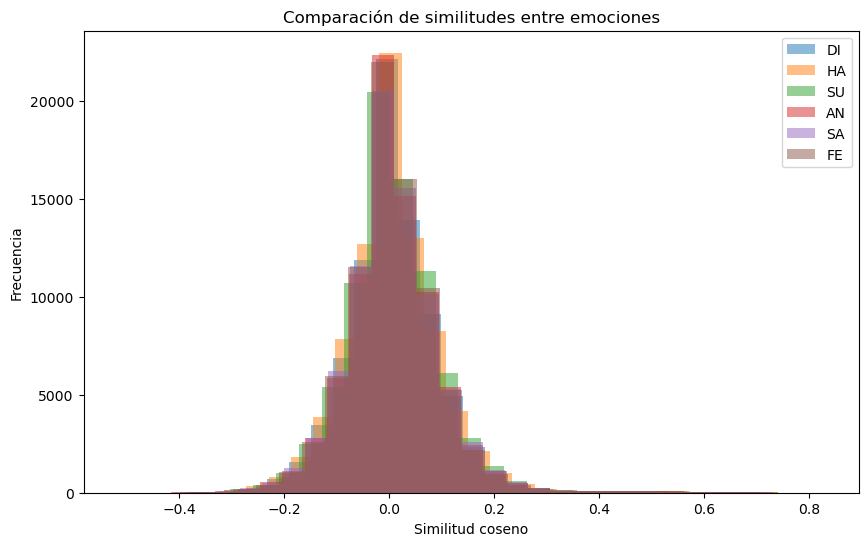

{'DI': array([0.66268677, 0.52509266, 0.5000259 , ..., 0.        , 0.        ,
        0.47615874], dtype=float32),
 'HA': array([0.5612551 , 0.5541737 , 0.6149448 , ..., 0.59128153, 0.64228547,
        0.5784504 ], dtype=float32),
 'SU': array([0.6054234 , 0.61220425, 0.70980036, ..., 0.55832297, 0.62132794,
        0.5226671 ], dtype=float32),
 'AN': array([0.4908953 , 0.5661207 , 0.68134975, ..., 0.4595906 , 0.38004407,
        0.65344846], dtype=float32),
 'SA': array([0.64128923, 0.50098085, 0.5865021 , ..., 0.58188444, 0.7480596 ,
        0.52117944], dtype=float32),
 'FE': array([0.55631614, 0.        , 0.56297827, ..., 0.44442376, 0.636482  ,
        0.44026756], dtype=float32)}

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


def comparacion_distancias_coseno(df):
    """Calcula distancias coseno entre todos los vectores por emoción y los plottea"""
    df = restar_vectores_neutros(df)
    results = {}  # Diccionario para guardar los resultados
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    all_distances = []  # Para almacenar todas las distancias y comparar entre emociones
    
    plt.figure(figsize=(12, 8))
    
    for i, emotion in enumerate(emotions):
        subset = df[df['exp'] == emotion]
        vectors = np.stack(subset['adjusted_vector'].values)
        vectors = normalize_vectors(vectors)
        
        # Calcular la matriz de similitud coseno
        similarity_matrix = cosine_similarity(vectors.reshape(len(vectors), -1))
        
        # Extraer solo los valores superiores de la matriz (sin la diagonal)
        triu_indices = np.triu_indices_from(similarity_matrix, k=1)
        similarities = similarity_matrix[triu_indices]
        results[emotion] = similarities  # Guardamos las distancias
        all_distances.append(similarities)
        
        # Graficar histograma para esta emoción
        plt.subplot(2, 3, i + 1)
        plt.hist(similarities, bins=30, alpha=0.7, color='b')
        plt.title(f'Similitud coseno para {emotion}')
        plt.xlabel('Similitud coseno')
        plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()
    
    # Comparación entre emociones
    plt.figure(figsize=(10, 6))
    for similarities, emotion in zip(all_distances, emotions):
        plt.hist(similarities, bins=30, alpha=0.5, label=emotion)
    
    plt.xlabel('Similitud coseno')
    plt.ylabel('Frecuencia')
    plt.title('Comparación de similitudes entre emociones')
    plt.legend()
    plt.show()
    
    return results


comparacion_distancias_coseno(df)

## Método 1: Promedio de promedios

In [46]:
def metodo_1(df):
    """Método 1: Promedio de promedios, por emoción."""
    results = {}
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    for emotion in emotions:
        subset_emocion = df[df['exp'] == emotion]
        promedios_emocion = []
        for idUnique in subset_emocion['idUnique'].unique():
            subset_emocion_persona = subset_emocion[subset_emocion['idUnique'] == idUnique]
            promedio_emocion_persona = np.mean(subset_emocion_persona['adjusted_vector'], axis=0)
            promedios_emocion.append(promedio_emocion_persona)
        promedio_de_promedios_emocion = np.mean(promedios_emocion, axis = 0)
        results[emotion] = promedio_de_promedios_emocion
    return results

metodo_1(df)

{'DI': array([[[-0.0075795 , -0.18286672,  0.03801309, ..., -0.05358843,
           0.18798694, -0.10529214],
         [-0.0075795 , -0.18286672,  0.03801309, ..., -0.05358843,
           0.18798694, -0.10529214],
         [-0.0075795 , -0.18286672,  0.03801309, ..., -0.05358843,
           0.18798694, -0.10529214],
         ...,
         [-0.0075795 , -0.18286672,  0.03801309, ..., -0.05358843,
           0.18798694, -0.10529214],
         [-0.0075795 , -0.18286672,  0.03801309, ..., -0.05358843,
           0.18798694, -0.10529214],
         [-0.0075795 , -0.18286672,  0.03801309, ..., -0.05358843,
           0.18798694, -0.10529214]]], dtype=float32),
 'HA': array([[[ 0.01833157, -0.06215676,  0.06698313, ..., -0.04951796,
           0.3515549 , -0.30000624],
         [ 0.01833157, -0.06215676,  0.06698313, ..., -0.04951796,
           0.3515549 , -0.30000624],
         [ 0.01833157, -0.06215676,  0.06698313, ..., -0.04951796,
           0.3515549 , -0.30000624],
         ...,
      

## Método 2: Promedio y luego regresión lineal

In [50]:
def metodo_2(df):
    """Método 2: Promedio y luego regresión lineal, por emoción."""
    results = {}
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    for emotion in emotions:
        subset_emocion = df[df['exp'] == emotion]
        promedios_por_persona = []
        for idUnique in subset_emocion['idUnique'].unique():
            subset_emocion_persona = subset_emocion[subset_emocion['idUnique'] == idUnique]
            promedios_por_persona.append(np.mean(subset_emocion_persona['adjusted_vector'], axis=0))
        if (len(promedios_por_persona) != 100):
            print(f'[ADVERTENCIA] El tamaño del vector de promedios por persona debería ser 100 y es {len(promedios_por_persona)}.')

        
        X = np.arange(len(promedios_por_persona)).reshape(-1, 1) 
        y = np.array(promedios_por_persona).reshape(np.array(promedios_por_persona).shape[0], -1)  # Aplanamos los vectores antes de la regresión

        #print(f'El vector X tiene la forma {X.shape} y el vector y tiene la forma {y.shape}.')
        #print(f'Para la emoción {emotion} el vector X es {X} y el vector y es {y}.')

        
        model = LinearRegression().fit(X, y)
        results[emotion] = model.coef_.reshape(1, 18, 512)  # Restauramos la forma original
            
        ## results[emotion] = promedio_de_promedios_emocion
    return results

metodo_2(df)

{'DI': array([[[ 0.00490124, -0.0053514 ,  0.00841095, ..., -0.00293802,
          -0.00452415, -0.00517821],
         [ 0.00490124, -0.0053514 ,  0.00841095, ..., -0.00293802,
          -0.00452415, -0.00517821],
         [ 0.00490124, -0.0053514 ,  0.00841095, ..., -0.00293802,
          -0.00452415, -0.00517821],
         ...,
         [ 0.00490124, -0.0053514 ,  0.00841095, ..., -0.00293802,
          -0.00452415, -0.00517821],
         [ 0.00490124, -0.0053514 ,  0.00841095, ..., -0.00293802,
          -0.00452415, -0.00517821],
         [ 0.00490124, -0.0053514 ,  0.00841095, ..., -0.00293802,
          -0.00452415, -0.00517821]]]),
 'HA': array([[[ 0.00765027, -0.00052225,  0.01561712, ..., -0.00587509,
          -0.00014264, -0.0023929 ],
         [ 0.00765027, -0.00052225,  0.01561712, ..., -0.00587509,
          -0.00014264, -0.0023929 ],
         [ 0.00765027, -0.00052225,  0.01561712, ..., -0.00587509,
          -0.00014264, -0.0023929 ],
         ...,
         [ 0.00765027

## Comparación de Métodos 1 y 2

In [48]:
from scipy.spatial.distance import cosine
import numpy as np

# Función para calcular la similitud coseno entre dos vectores
def cosine_similarity(v1, v2):
    return 1 - cosine(v1.flatten(), v2.flatten())

# Función para comparar método 1 vs método 3
def compare_results(results1, results3):
    similarities = {}
    for emotion in results1.keys():
        similarities[emotion] = cosine_similarity(results1[emotion], results3[emotion])
    return similarities

print(compare_results(metodo_1(df), metodo_2(df)))

{'DI': 0.051983787036087414, 'HA': -0.017859053148949755, 'SU': 0.03262427946499291, 'AN': -0.03727021840082112, 'SA': -0.08329290050176663, 'FE': -0.004203996946469113}


In [65]:
import subprocess

def generate_one_image_from_npz(npz, image_name):

    np.savez(f"images/processed_images/{image_name}_01_projected_w.npz", npz)
    
    npz_path = f"/scratch/images/processed_images/{image_name}_01_projected_w.npz"
    outdir_path = "/scratch/images/generated_images"
    
    command = ["/mnt/discoAmpliado/viky/stylegan2-ada-pytorch/docker_run.sh",
        "python",
        "stylegan2-ada-pytorch/generate.py",
        "--network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl",
        f"--outdir={outdir_path}",
        f"--projected-w={npz_path}"
    ]    
    print(f"Ejecutando para la imagen: {image_name}")
    print(f"Comando: {' '.join(command)}")
    subprocess.run(command, check=True)



imagen_modificada = getNPZ(df['name'][0]) + metodo_2(df)['HA']
generate_one_image_from_npz(imagen_modificada, "imagen_de_prueba")

Ejecutando para la imagen: imagen_de_prueba
Comando: /mnt/discoAmpliado/viky/stylegan2-ada-pytorch/docker_run.sh python stylegan2-ada-pytorch/generate.py --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl --outdir=/scratch/images/generated_images --projected-w=/scratch/images/processed_images/imagen_de_prueba_01_projected_w.npz


the input device is not a TTY


CalledProcessError: Command '['/mnt/discoAmpliado/viky/stylegan2-ada-pytorch/docker_run.sh', 'python', 'stylegan2-ada-pytorch/generate.py', '--network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl', '--outdir=/scratch/images/generated_images', '--projected-w=/scratch/images/processed_images/imagen_de_prueba_01_projected_w.npz']' returned non-zero exit status 1.

---

# Código legacy

In [ ]:

def method_1_average_then_regression(df):
    """Método 1: Promedia los vectores por emoción y aplica regresión."""
    results = {}
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    for emotion in emotions:
        subset = df[df['exp'] == emotion]
        vectors = np.array([getNPZ(name) for name in subset['name']])
        vectors = normalize_vectors(vectors)
        avg_vector = np.mean(vectors, axis=0) # Podemos hacer promedio de promedios
        
        X = np.arange(len(vectors)).reshape(-1, 1) # por qué no usamos avg_vectors?
        y = vectors.reshape(vectors.shape[0], -1)  # Aplanamos los vectores antes de la regresión

        model = LinearRegression().fit(X, y)
        results[emotion] = model.coef_.reshape(1, 18, 512)  # Restauramos la forma original
    
    return results

def method_2_regression_by_emotion_and_level(df):
    """Método 2: Aplica regresión a cada emoción y nivel de intensidad."""
    results = {}
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    for emotion in emotions:
        results[emotion] = {}  # Ahora almacenamos los resultados por nivel
        
        for level in sorted(df['exp_level'].unique()):
            subset = df[(df['exp'] == emotion) & (df['exp_level'] == level)]
            if subset.empty:
                continue
            vectors = np.array([getNPZ(name) for name in subset['name']])
            vectors = normalize_vectors(vectors)
            
            X = np.arange(len(vectors)).reshape(-1, 1)
            y = vectors.reshape(vectors.shape[0], -1)  # Aplanamos los vectores antes de la regresión
            
            model = LinearRegression().fit(X, y)
            results[emotion][level] = model.coef_.reshape(1, 18, 512)  # Guardamos cada nivel separadamente
    
    return results

def method_3_regression_with_level_variable(df): # Este volver a chequear qué hace
    """Método 3: Incluye el nivel como variable numérica en la regresión."""
    results = {}
    emotions = ['DI', 'HA', 'SU', 'AN', 'SA', 'FE']
    
    for emotion in emotions:
        subset = df[df['exp'] == emotion]
        vectors = np.array([getNPZ(name) for name in subset['name']])
        vectors = normalize_vectors(vectors)
        levels = subset['exp_level'].values.reshape(-1, 1)

        y = vectors.reshape(vectors.shape[0], -1)
        
        model = LinearRegression().fit(levels, y)
        results[emotion] = model.coef_.reshape(1, 18, 512)
    
    return results

def save_results_as_csv(results, filename):
    flat_results = {}
    
    for key, value in results.items():
        flat_results[key] = value.flatten()  # Aplanar la matriz
    
    df = pd.DataFrame.from_dict(flat_results, orient='index')
    df.to_csv(filename)

    save_results_as_csv(method_1_results, 'method_1_results.csv')


def save_results_as_npz(results, filename):
    """Guarda los resultados en un archivo NPZ."""
    np.savez(filename, **results)

## Ejecutar los 3 métodos y guardar como npz

In [ ]:
method_1_results = method_1_average_then_regression(df)
method_2_results = method_2_regression_by_emotion_and_level(df)
method_3_results = method_3_regression_with_level_variable(df)

print("Imprimo shape de uno de los vectores para controlar formato:")
print("Resultados método 1, 'DI': " + str(method_1_results['DI'].shape))
print("Resultados método 2, 'DI': " + str(method_2_results['DI'][1].shape))
print("Resultados método 3, 'DI': " + str(method_3_results['DI'].shape))

# Guardar resultados
save_results_as_npz(method_1_results, 'method_1_results.npz')
save_results_as_npz(method_2_results, 'method_2_results.npz')
save_results_as_npz(method_3_results, 'method_3_results.npz')

## Printeo la forma de los diccionarios para saber con qué estoy trabajando

In [ ]:
def print_shape(diccionario, indent=0):
    for clave, valor in diccionario.items():
        # Indentación para la estructura
        print("  " * indent + f"Clave: {clave}", end=' ')
        
        if isinstance(valor, dict):
            # Si el valor es otro diccionario, lo recorremos recursivamente
            print("; Valor: Diccionario con las siguientes claves: ")
            print_shape(valor, indent + 1)
        elif isinstance(valor, np.ndarray):
            # Si el valor es un array de NumPy, mostramos su forma
            print(f"; Valor: Array de la forma {valor.shape}")
        elif isinstance(valor, list):
            # Si el valor es una lista, mostramos su longitud
            print(f"(Lista) - Shape: {len(valor)}")
        else:
            # Si no es ni diccionario, ni array ni lista, solo mostramos el tipo
            print(f"({type(valor).__name__})")

print("Forma del diccionario correspondiente al método 1: ")
print_shape(method_1_results)
print("Fin del diccionario correspondiente al método 1.\n")
print("Forma del diccionario correspondiente al método 2: ")
print_shape(method_2_results)
print("Fin del diccionario correspondiente al método 2.\n")
print("Forma del diccionario correspondiente al método 3: ")
print_shape(method_3_results)
print("Fin del diccionario correspondiente al método 3.\n")

## Intentando analisis de datos

## 1. Similitud coseno

In [ ]:
from scipy.spatial.distance import cosine
import numpy as np

# Función para calcular la similitud coseno entre dos vectores
def cosine_similarity(v1, v2):
    return 1 - cosine(v1.flatten(), v2.flatten())

In [ ]:
# Función para comparar método 1 vs método 3
def compare_results(results1, results3):
    similarities = {}
    for emotion in results1.keys():
        similarities[emotion] = cosine_similarity(results1[emotion], results3[emotion])
    return similarities

In [ ]:
print(compare_results(method_1_results, method_3_results))

In [ ]:
import matplotlib.pyplot as plt

a = [1, 1]
b = [1, 2]
c = [2, 1]
#X = 
#y = 

plt.scatter(a, b)
plt.show()


#model = LinearRegression().fit(X, y)
#results[emotion] = model.coef_.reshape(1, 18, 512)